In [6]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
from os import listdir
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
import tensorflow
from tensorflow.keras import optimizers
# from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
# from keras.preprocessing import image
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from keras.models import Model
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
width=64
height=64
depth=3
image_size = 0
directory_root = "C://Users//9942038100//Desktop//UNI-Project//input"


In [12]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :", e)
        return None

image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
    
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
    for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")            
image_size = len(image_list) #num of imgs
print(image_size) 
label_binarizer =LabelBinarizer() # convert lable to 0/1
image_labels = label_binarizer.fit_transform(label_list) # to reduce the range to (0-1)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_) 
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.10, random_state = 42)
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
inputShape = (height, width, depth)


[INFO] Loading images ...
[INFO] Processing dieseased ...
[INFO] Processing healthy ...
[INFO] Image loading completed
3100
['dieseased' 'healthy']
[INFO] Spliting data to train, test


In [13]:
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size =(2,2)))
classifier.add(Conv2D(32,(3,3))) 
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size =(2,2)))
classifier.add(Conv2D(32,(3,3))) 
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size =(2,2)))
classifier.add(Flatten())
classifier.add(Dense(64))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))

In [14]:
#Model Compiling
classifier.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
classifier.summary()   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 activation_5 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 29, 29, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                  

c:\Users\9942038100\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [16]:
history = classifier.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train)//BS,
    epochs=EPOCHS, verbose=1,
    callbacks=callbacks
    )

Epoch 1/25


C:\Users\9942038100\AppData\Local\Temp\ipykernel_2544\933490869.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = classifier.fit_generator(


87/87 [==============================] - 10s 101ms/step - loss: 0.6894 - acc: 0.4993 - val_loss: 0.6915 - val_acc: 0.4710 - lr: 2.0000e-05
Epoch 2/25
87/87 [==============================] - 9s 102ms/step - loss: 0.6860 - acc: 0.5174 - val_loss: 0.6858 - val_acc: 0.4710 - lr: 2.0000e-05
Epoch 3/25
87/87 [==============================] - 8s 88ms/step - loss: 0.6778 - acc: 0.5172 - val_loss: 0.6765 - val_acc: 0.4903 - lr: 2.0000e-05
Epoch 4/25
87/87 [==============================] - 8s 86ms/step - loss: 0.6717 - acc: 0.5344 - val_loss: 0.6680 - val_acc: 0.5290 - lr: 2.0000e-05
Epoch 5/25
87/87 [==============================] - 7s 85ms/step - loss: 0.6618 - acc: 0.5732 - val_loss: 0.6544 - val_acc: 0.5968 - lr: 2.0000e-05
Epoch 6/25
87/87 [==============================] - 8s 90ms/step - loss: 0.6473 - acc: 0.6276 - val_loss: 0.6353 - val_acc: 0.7161 - lr: 2.0000e-05
Epoch 7/25
87/87 [==============================] - 7s 86ms/step - loss: 0.6286 - acc: 0.6820 - val_loss: 0.6146 - val_a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


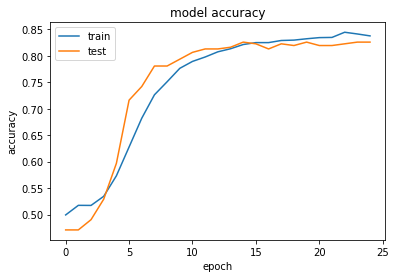

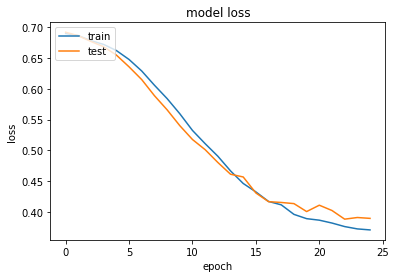

In [17]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
import h5py
classifier.save('trained_model4.h5')